## Tutoriel : interagir avec le système de stockage S3 du SSP Cloud (MinIO)

In [2]:
! pip install nltk
! pip install datasets
! pip install tiktoken
! pip install spacy

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import os

import pandas as pd
import s3fs
import zipfile
import matplotlib.pyplot as plt
from nltk import word_tokenize

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import tiktoken
import nltk

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

from itertools import chain
from collections import Counter
import json

### Récupérer les données d'un challenge

In [4]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

# Lister les challenges
#fs.ls("gvimont/diffusion/hackathon-minarm-2024")

# Lister les fichiers d'un challenge
fs.ls("civel/diffusion/hackathon-minarm-2024/AIVSAI")

['civel/diffusion/hackathon-minarm-2024/AIVSAI/.keep',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/all.json',
 'civel/diffusion/hackathon-minarm-2024/AIVSAI/train.json']

In [5]:
# Télécharger les données dans le service
PATH_IN = 'civel/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip'
fs.download(PATH_IN, 'data/HC3.zip')

# Décompresser les données
with zipfile.ZipFile("data/HC3.zip","r") as zip_file:
    zip_file.extractall("data/")

NB : les données peuvent être également téléchargées directement si besoin, pour être utilisées hors du SSP CLoud.
Exemple pour le fichier ci-dessus (même format de lien pour les autres challenges) : 

http://minio.lab.sspcloud.fr/gvimont/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip

### Exporter des données

In [6]:
def load_jsonl_files():
    file_path = "data/HC3/all.jsonl"
    dfs = pd.read_json(file_path, lines=True)
    return dfs

df = load_jsonl_files()
df

,question,human_answers,chatgpt_answers,index,source
0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",[There are many different best seller lists th...,NaN,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,[Salt is used on roads to help melt ice and sn...,NaN,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,[There are a few reasons why we still have SD ...,NaN,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,[It is generally not acceptable or ethical to ...,NaN,reddit_eli5
4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,[After the Wright Brothers made the first powe...,NaN,reddit_eli5
...,...,...,...,...,...
24317,Is rise in pressure from 116/66 to 140/80 norm...,[Hello!Welcome and thank you for asking on HCM...,[It's not uncommon for blood pressure to fluct...,NaN,medicine
24318,What could cause a painless lump in the right ...,"[Hi, * As per my surgical experience, the issu...",[There are several possible causes of a painle...,NaN,medicine
24319,Can Acutret be given to a child for treatment ...,[Although it is difficult to comment whether A...,[It is not appropriate for me to recommend a s...,NaN,medicine
24320,Are BP of 119/65 and pulse of 35 causes for co...,[Welcome and thank you for asking on HCM! I ha...,[It is not uncommon for people with rheumatoid...,NaN,medicine


### Clean questions

In [7]:
def clean_question(question):
    # Remove if question starts with 'Q.'
    return question[3:].strip() if question[:3] == 'Q. ' else question

def clean_questions(df):
    df_cleaned = df.copy()
    
    df_cleaned['question'] = df_cleaned['question'].apply(lambda x: clean_question(x))
    
    return df_cleaned

### Clean Answers

In [8]:
def clean_answer(answer):
    # Transform list answer into string
    return ' '.join(answer) if isinstance(answer, list) else answer

def clean_answers(df):
    df_cleaned = df.copy()
    
    df_cleaned['human_answers'] = df_cleaned['human_answers'].apply(lambda x: clean_answer(x))
    df_cleaned['chatgpt_answers'] = df_cleaned['chatgpt_answers'].apply(lambda x: clean_answer(x))
    
    return df_cleaned

In [9]:
def clean_type_data(df) :
    
    df_cleaned = df.copy()
    df_cleaned['human_answers'].astype(str)
    df_cleaned['chatgpt_answers'].astype(str)
    
    return df_cleaned

### Clean Dataframe

In [10]:
def clean_dataframe(df):
    df = clean_answers(df)
    df = df.drop_duplicates()
    df = clean_questions(df)
    df = clean_type_data(df)
    if 'index' in df.columns :
        df = df.drop(columns="index")
    df = df.dropna()
    
    return df

In [11]:
df = clean_dataframe(df)
df

,question,human_answers,chatgpt_answers,source
0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",There are many different best seller lists tha...,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,Salt is used on roads to help melt ice and sno...,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,The way it works is that old TV stations got a...,There are a few reasons why we still have SD (...,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,You ca n't just go around assassinating the le...,It is generally not acceptable or ethical to a...,reddit_eli5
4,How was airplane technology able to advance so...,Wanting to kill the shit out of Germans drives...,After the Wright Brothers made the first power...,reddit_eli5
...,...,...,...,...
24317,Is rise in pressure from 116/66 to 140/80 norm...,Hello!Welcome and thank you for asking on HCM!...,It's not uncommon for blood pressure to fluctu...,medicine
24318,What could cause a painless lump in the right ...,"Hi, * As per my surgical experience, the issue...",There are several possible causes of a painles...,medicine
24319,Can Acutret be given to a child for treatment ...,Although it is difficult to comment whether Ac...,It is not appropriate for me to recommend a sp...,medicine
24320,Are BP of 119/65 and pulse of 35 causes for co...,Welcome and thank you for asking on HCM! I hav...,It is not uncommon for people with rheumatoid ...,medicine


In [12]:
# Export vers un bucket personnel
PATH_OUT = 'juliettejin/diffusion/projet-mongroupe-hackathon/all_dataset.csv'
with fs.open(PATH_OUT, 'w') as file_out:
    df.to_csv(file_out, index=False)

In [13]:
# NB : le dossier 'diffusion' permet un accès en lecture à tous les membres du groupe !
# Tous les membres peuvent donc le voir et l'utiliser dans un service
fs.ls("juliettejin/diffusion/projet-mongroupe-hackathon")

['juliettejin/diffusion/projet-mongroupe-hackathon/all_dataset.csv',
 'juliettejin/diffusion/projet-mongroupe-hackathon/medicine.csv']

In [14]:
with fs.open(PATH_OUT, mode="r") as file_in:
    df_test = pd.read_csv(file_in)
    df_test = clean_dataframe(df_test)

In [15]:
df_test.head()

,question,human_answers,chatgpt_answers,source
0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",There are many different best seller lists tha...,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,Salt is used on roads to help melt ice and sno...,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,The way it works is that old TV stations got a...,There are a few reasons why we still have SD (...,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,You ca n't just go around assassinating the le...,It is generally not acceptable or ethical to a...,reddit_eli5
4,How was airplane technology able to advance so...,Wanting to kill the shit out of Germans drives...,After the Wright Brothers made the first power...,reddit_eli5


# Tokenizer

In [16]:
sources = ['finance','wiki_csai','open_qa','medicine','reddit_eli5']
answers_by_source = {source: " ".join(df.loc[df['source'] == source, 'human_answers']) for source in df['source'].unique()}

In [17]:
def nltk_tokenize(doc: str) -> list[str]:
    return word_tokenize(doc)

def gpt_tokenize(doc: str) -> list:
    enc = tiktoken.encoding_for_model("gpt-4")
    tokens = enc.encode(doc)
    return [str(token) for token in tokens]

In [18]:
def tokenize(doc: str, base_tokenizer=word_tokenize, do_lower=False, do_remove_stop_word=False, custom_stop_words=[], do_lemmatize=False) -> tuple[list,list]:
    if do_lower:
        doc = doc.lower()
    list_token = base_tokenizer(doc)

    if do_remove_stop_word:
        stop_words = en_stop | set("-.!?()_;:,'[]$%*/|\\") | {'...'} | {"''"} | {"``"} | set(custom_stop_words) 
        list_token = [token for token in list_token if token not in stop_words]
        
    if do_lemmatize:
        wnl = WordNetLemmatizer()
        list_token = [wnl.lemmatize(t) for t in list_token]

    return list_token

def use_tokenizer(tokenizer, base_tokenizer=word_tokenize):
    return tokenizer

def remove_stop_words(custom_stop_words):
    return custom_stop_words

def add_stop_words(words, custom_stop_words):
    custom_stop_words.extend(words)
    return custom_stop_words

def lower():
    return True

def lemmatize():
    return True

In [19]:
custom_stop_words = []
list_token_per_source = {}
for source in sources:
    list_token_per_source[source] = tokenize(answers_by_source[source], do_lower=True, do_remove_stop_word=True, custom_stop_words=custom_stop_words)

In [20]:
for source, list_token in list_token_per_source.items():
    word_counts = Counter(list_token)
    top_10_words = word_counts.most_common(10)
    print(source,":\n", top_10_words)

finance :
 [('money', 2654), ('price', 1839), ('tax', 1807), ('stock', 1807), ('pay', 1730), ('market', 1637), ('company', 1632), ('time', 1456), ('income', 1417), ('credit', 1401)]
wiki_csai :
 [('data', 902), ('computer', 580), ('learning', 424), ('systems', 420), ('system', 364), ('information', 358), ('science', 356), ('machine', 326), ('intelligence', 318), ('artificial', 311)]
open_qa :
 [('states', 188), ('united', 170), ('american', 117), ('known', 104), ('world', 60), ('war', 59), ('state', 57), ('city', 51), ('new', 50), ('u.s.', 49)]
medicine :
 [('hi', 467), ('query', 455), ('like', 417), ('hope', 401), ('pain', 384), ('hello', 354), ('need', 322), ('care', 314), ('help', 298), ('consult', 292)]
reddit_eli5 :
 [('like', 20263), ('people', 19320), ('time', 12497), ('way', 9323), ('things', 8575), ('use', 7863), ('different', 7799), ('lot', 7669), ('know', 7166), ('money', 6911)]


In [21]:
file_path = 'list_token_per_source.json'

# Open the file in write mode
with open(file_path, 'w') as json_file:
    # Write the dictionary to the file
    json.dump(list_token_per_source, json_file, indent=4)

print("Dictionary has been written to", file_path)

Dictionary has been written to list_token_per_source.json


# Compare the length of the answer between human and ChatGPT

In [22]:
def compareLengthAnswer(data, category="") :

    #Collect the length of the answer
    if (category == "") :
        lengthHumanAnswer = data['human_answers'].apply(len)
        lengthChatGPTAnswer = data['chatgpt_answers'].apply(len)
    else :
        lengthHumanAnswer = data[data['source'] == category]['human_answers'].apply(len)
        lengthChatGPTAnswer = data[data['source'] == category]['chatgpt_answers'].apply(len)
    
    # Display the graphic
    plt.figure(figsize=(10, 6))
    plt.hist(lengthHumanAnswer, bins=20, alpha=0.5, label='Human Answers')
    plt.hist(lengthChatGPTAnswer, bins=20, alpha=0.5, label='ChatGPT Answers')
    plt.title('Comparaison de la taille des réponses')
    plt.xlabel('Quantité de caractères par réponse')
    plt.ylabel('Quantité de réponse')
    plt.legend()
    plt.grid(True)
    plt.show()

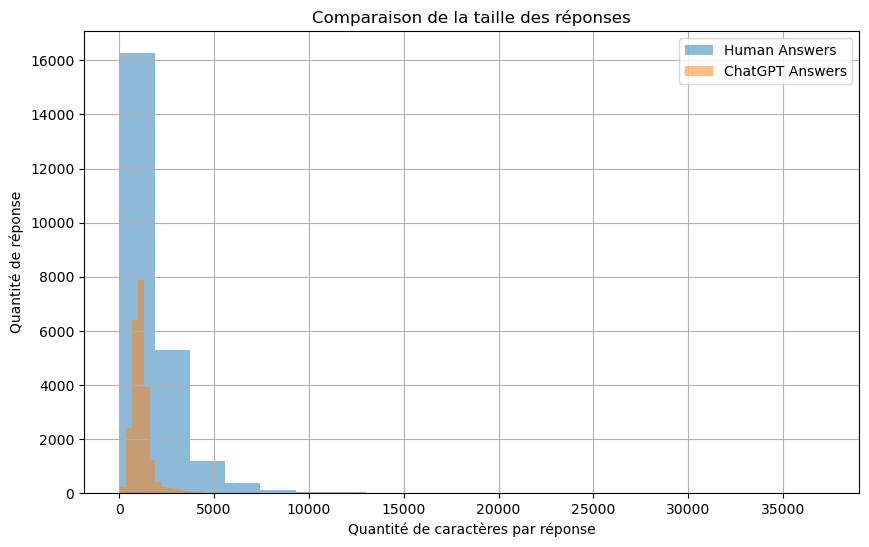

In [23]:
compareLengthAnswer(df_test)

In [24]:
df_wiki = df_test[df_test['source'] == 'wiki_csai']['human_answers']


In [25]:
df_test.head()

,question,human_answers,chatgpt_answers,source
0,"Why is every book I hear about a "" NY Times # ...","Basically there are many categories of "" Best ...",There are many different best seller lists tha...,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",salt is good for not dying in car crashes and ...,Salt is used on roads to help melt ice and sno...,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,The way it works is that old TV stations got a...,There are a few reasons why we still have SD (...,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,You ca n't just go around assassinating the le...,It is generally not acceptable or ethical to a...,reddit_eli5
4,How was airplane technology able to advance so...,Wanting to kill the shit out of Germans drives...,After the Wright Brothers made the first power...,reddit_eli5


### Count number of sentences 

In [26]:
import re
def count_sentences(text):
    # Utiliser regex pour détecter la fin des phrases avec plus de précision
    sentences = re.split(r'(?<=[.!?])\s+', text)
    # Retourner le nombre de phrases, en s'assurant qu'on ne compte pas les éléments vides
    return len([sentence for sentence in sentences if sentence.strip()])

# Appliquer la fonction de comptage sur les colonnes des réponses et créer de nouvelles colonnes pour les comptes
df['human_sentence_count'] = df['human_answers'].apply(count_sentences)
df['chatgpt_sentence_count'] = df['chatgpt_answers'].apply(count_sentences)

# Grouper par la colonne 'source' et calculer la somme des phrases pour chaque source
grouped = df.groupby('source').agg({
    'human_sentence_count': 'sum',
    'chatgpt_sentence_count': 'sum'
}).reset_index()

grouped

,source,human_sentence_count,chatgpt_sentence_count
0,finance,35280,25627
1,medicine,6558,11801
2,open_qa,1351,15928
3,reddit_eli5,322703,124197
4,wiki_csai,6800,6521


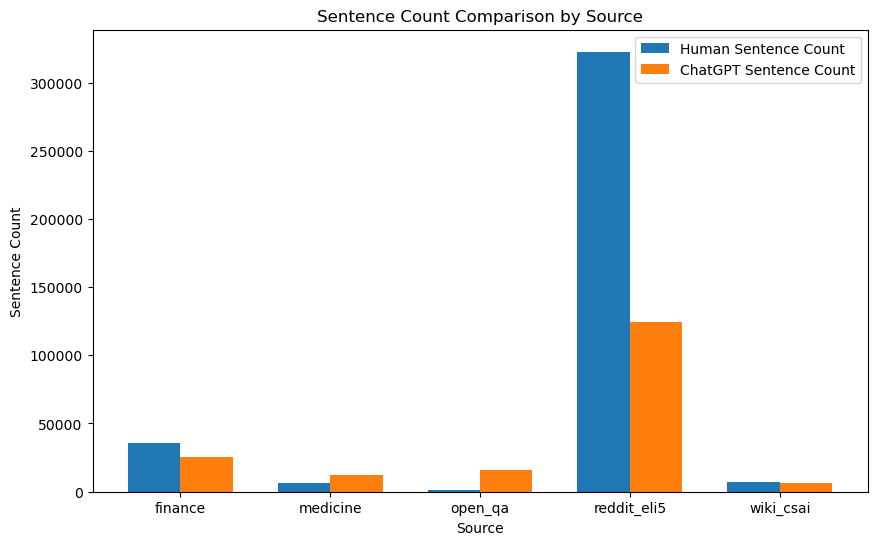

In [27]:
import matplotlib.pyplot as plt
import numpy as np

positions = np.arange(len(grouped['source']))

fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35

# Create bars
human_bars = ax.bar(positions - width/2, grouped['human_sentence_count'],width, label='Human Sentence Count')
chatgpt_bars = ax.bar(positions + width/2, grouped['chatgpt_sentence_count'], width, label='ChatGPT Sentence Count')

ax.set_xlabel('Source')
ax.set_ylabel('Sentence Count')
ax.set_title('Sentence Count Comparison by Source')
ax.set_xticks(positions)
ax.set_xticklabels(grouped['source'])
ax.legend()
plt.show()


## Correlation between answers and questions length

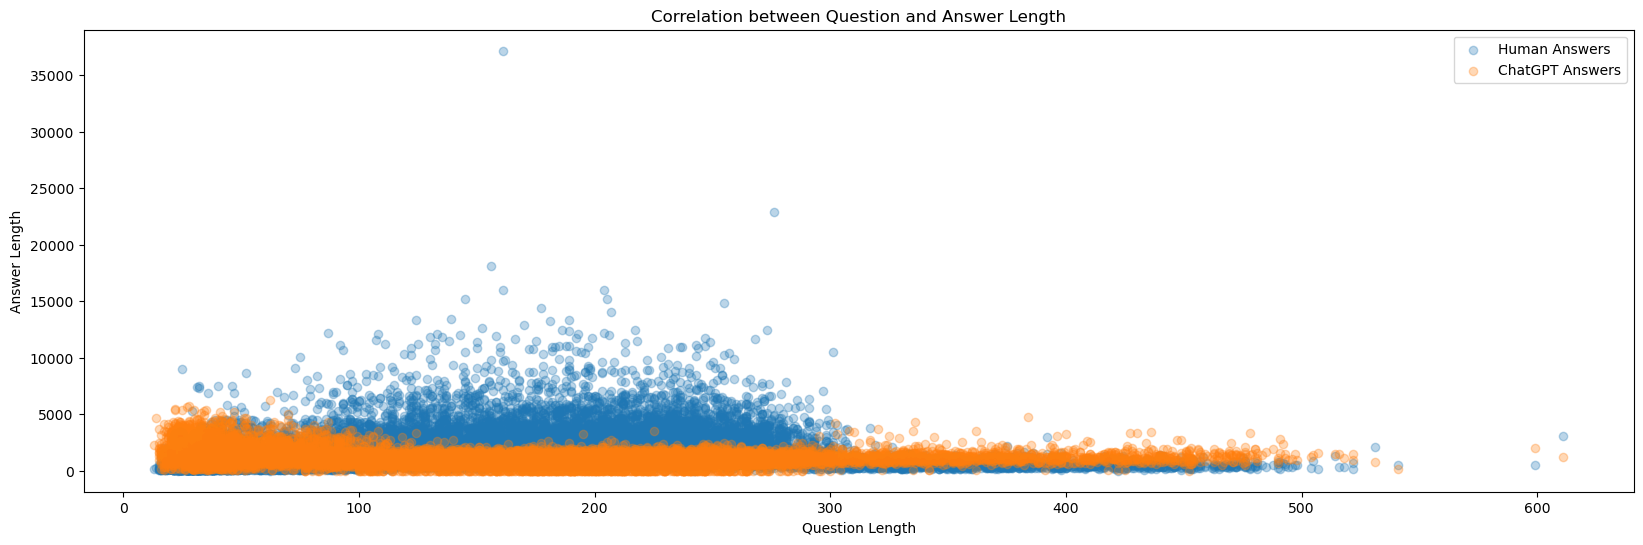

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

df_plot = df.copy()

df_plot['question_length'] = df['question'].apply(len)
df_plot['human_answer_length'] = df['human_answers'].apply(len)
df_plot['chatgpt_answer_length'] = df['chatgpt_answers'].apply(len)

plt.figure(figsize=(20, 6))

# Scatter plot for Q and A
plt.scatter(df_plot['question_length'], df_plot['human_answer_length'], label='Human Answers', alpha=0.3)
plt.scatter(df_plot['question_length'], df_plot['chatgpt_answer_length'], label='ChatGPT Answers', alpha=0.3)

plt.xlabel('Question Length')
plt.ylabel('Answer Length')
plt.title('Correlation between Question and Answer Length')
plt.legend()
plt.show()

# Regression Logistic

In [29]:
dataset = pd.DataFrame({
    'answers': df['human_answers'].tolist() + df['chatgpt_answers'].tolist(),
    'category': [0] * len(df) + [1] * len(df)
})

In [30]:
X = dataset['answers']  # Features (questions)
y = dataset['category']  # Target variable (answers)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
text_transformer = CountVectorizer()
X_train_vectorized = text_transformer.fit_transform(X_train)
X_test_vectorized = text_transformer.transform(X_test)

In [32]:
model = LogisticRegression(random_state=42, solver='liblinear')

In [33]:
model.fit(X_train_vectorized, y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [34]:
y_pred = model.predict(X_test_vectorized)

In [35]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      4740
           1       0.96      0.94      0.95      4786

    accuracy                           0.95      9526
   macro avg       0.95      0.95      0.95      9526
weighted avg       0.95      0.95      0.95      9526

